## Semester 1 Project Submission

Please fill out:
* Student name: 
* Instructor name: 


In [1]:
# Your code here - remember to use markdown cells for comments as well!

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
# You'll need to unzip the db locally.
conn = sqlite3.connect('zippedData/im.db')

# Habib Khadri

# Nick Kirbabas

# Seerat Mutneja

# Sidhya Raman

# Douglas Riggs

In [3]:
# Reading table names
pd.read_sql('''
SELECT 
    name
FROM 
    sqlite_schema
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
''',conn)
#Adding a comment to initialize my branch

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## Function Definitions

In [4]:
# Used to convert Dollar value ($123,456,789) into int (123456789)
def dollar_str_to_int(cash_string):
    cash_string = cash_string.strip('$')
    cash_string = cash_string.replace(',', '')
    return int(cash_string)

## Join IMDB with TN Movie Budgets and TMDB,  and do some cleaning

In [5]:
# Reading and joining 2 tables from im.db. Left join, since we won't actually
# be using the rating/numvotes, and don't care if they're null
imdb_df = pd.read_sql('''
SELECT DISTINCT movie_id, primary_title, genres, averagerating, numvotes
FROM movie_basics
LEFT JOIN movie_ratings
    USING (movie_id)
''',conn)

In [6]:
# Check Column names/number of values
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   movie_id       146144 non-null  object 
 1   primary_title  146144 non-null  object 
 2   genres         140736 non-null  object 
 3   averagerating  73856 non-null   float64
 4   numvotes       73856 non-null   float64
dtypes: float64(2), object(3)
memory usage: 5.6+ MB


In [7]:
# Read data from tn.movie_budgets csv. We'll use this table for 
# budget/worldwide gross
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [8]:
# Check info
tn_movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [9]:
# Joining the imdb df and the tn df on movie name.
imdb_df = imdb_df.set_index('primary_title')
tn_movie_budgets_df = tn_movie_budgets_df.set_index('movie')
imdb_tn_df = imdb_df.join(tn_movie_budgets_df, how='inner')
imdb_df = imdb_df.reset_index()
tn_movie_budgets_df = tn_movie_budgets_df.reset_index()
imdb_tn_df = imdb_tn_df.reset_index()
# Rename index -> primary_title
imdb_tn_df.columns = ['primary_title', 'movie_id', 'genres', 'averagerating',
                      'numvotes', 'id', 'release_date', 'production_budget', 
                      'domestic_gross', 'worldwide_gross']

In [10]:
# Take a peek at the resulting table
imdb_tn_df.head()

,primary_title,movie_id,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross
0,#Horror,tt3526286,"Crime,Drama,Horror",3.0,3092.0,16,"Nov 20, 2015","$1,500,000",$0,$0
1,10 Cloverfield Lane,tt1179933,"Drama,Horror,Mystery",7.2,260383.0,54,"Mar 11, 2016","$5,000,000","$72,082,999","$108,286,422"
2,10 Days in a Madhouse,tt3453052,Drama,6.7,1114.0,48,"Nov 11, 2015","$12,000,000","$14,616","$14,616"
3,12 Rounds,tt3517850,"Action,Drama,Romance",8.1,11.0,37,"Mar 27, 2009","$20,000,000","$12,234,694","$17,306,648"
4,12 Strong,tt1413492,"Action,Drama,History",6.6,50155.0,64,"Jan 19, 2018","$35,000,000","$45,819,713","$71,118,378"


In [11]:
# And check columns/number of values
imdb_tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3815 entries, 0 to 3814
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      3815 non-null   object 
 1   movie_id           3815 non-null   object 
 2   genres             3743 non-null   object 
 3   averagerating      2875 non-null   float64
 4   numvotes           2875 non-null   float64
 5   id                 3815 non-null   int64  
 6   release_date       3815 non-null   object 
 7   production_budget  3815 non-null   object 
 8   domestic_gross     3815 non-null   object 
 9   worldwide_gross    3815 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 298.2+ KB


In [12]:
# Convert $ strings to ints
imdb_tn_df['production_budget'] = imdb_tn_df.production_budget.map(dollar_str_to_int)
imdb_tn_df['domestic_gross'] = imdb_tn_df.domestic_gross.map(dollar_str_to_int)
imdb_tn_df['worldwide_gross'] = imdb_tn_df.worldwide_gross.map(dollar_str_to_int)

In [13]:
# Read data from tdmb csv. We'll use this table for 
# language, to filter out non-english movies
tmdb_movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')

In [14]:
# Join our existing dataframe with the tmdb dataframe
imdb_tn_df = imdb_tn_df.set_index('primary_title')
tmdb_movies_df = tmdb_movies_df.set_index('title')
imdb_tn_tmdb_df = imdb_tn_df.join(tmdb_movies_df, how='left', lsuffix='_left',\
                                  rsuffix='_right')
imdb_tn_df = imdb_tn_df.reset_index()
tmdb_movies_df = tmdb_movies_df.reset_index()
imdb_tn_tmdb_df = imdb_tn_tmdb_df.reset_index()
imdb_tn_tmdb_df.columns = ['primary_title', 'movie_id', 'genres', 
                           'averagerating', 'numvotes', 'id_left',
                           'release_date_left', 'production_budget', 
                           'domestic_gross', 'worldwide_gross', 'Unnamed: 0',
                           'genre_ids', 'id_right', 'original_language', 
                           'original_title', 'popularity', 'release_date_right',
                           'vote_average', 'vote_count']

In [15]:
# List info on the table
imdb_tn_tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   primary_title       5374 non-null   object 
 1   movie_id            5374 non-null   object 
 2   genres              5275 non-null   object 
 3   averagerating       3813 non-null   float64
 4   numvotes            3813 non-null   float64
 5   id_left             5374 non-null   int64  
 6   release_date_left   5374 non-null   object 
 7   production_budget   5374 non-null   int64  
 8   domestic_gross      5374 non-null   int64  
 9   worldwide_gross     5374 non-null   int64  
 10  Unnamed: 0          4550 non-null   float64
 11  genre_ids           4550 non-null   object 
 12  id_right            4550 non-null   float64
 13  original_language   4550 non-null   object 
 14  original_title      4550 non-null   object 
 15  popularity          4550 non-null   float64
 16  releas

In [16]:
# Filter out non-english movies
imdb_tn_tmdb_df = imdb_tn_tmdb_df[imdb_tn_tmdb_df.original_language == 'en']

In [17]:
# Drop duplicate movies based on movie name
imdb_tn_tmdb_df = imdb_tn_tmdb_df.drop_duplicates(subset=["primary_title"], keep='first')

Now, the imdb_tn_tmdb_df should be usable for analysis!

### Group based by Genre, Create visuals for that

In [18]:
# Splitting the genre column into separate rows for each listed genre
imdb_tn_df = imdb_tn_tmdb_df.reset_index()
imdb_tn_split_df = imdb_tn_df
imdb_tn_split_df = pd.DataFrame({'genres':imdb_tn_split_df.genres.str.split(','),\
                                 'movie':imdb_tn_split_df.primary_title}, )\
                        .explode('genres')

In [19]:
# Check that the result looks as expected
imdb_tn_split_df.head(2)

,genres,movie
0,Drama,10 Cloverfield Lane
0,Horror,10 Cloverfield Lane


In [20]:
# Join back with the original dataframe to get the rest of the columns, 
# since we only have genre and movie name.
imdb_tn_split_df = imdb_tn_split_df.set_index('movie');
imdb_tn_df = imdb_tn_df.set_index('primary_title')
imdb_tn_split_df = imdb_tn_split_df\
.join(imdb_tn_df, how='inner', lsuffix='_separated', rsuffix='_original')
imdb_tn_split_df.reset_index()
imdb_tn_df.reset_index();

In [21]:
# Check the result
imdb_tn_split_df.head()

,genres_separated,index,movie_id,genres_original,averagerating,numvotes,id_left,release_date_left,production_budget,domestic_gross,worldwide_gross,Unnamed: 0,genre_ids,id_right,original_language,original_title,popularity,release_date_right,vote_average,vote_count
10 Cloverfield Lane,Drama,1,tt1179933,"Drama,Horror,Mystery",7.2,260383.0,54,"Mar 11, 2016",5000000,72082999,108286422,17422.0,"[53, 878, 18]",333371.0,en,10 Cloverfield Lane,17.892,2016-03-11,6.9,4629.0
10 Cloverfield Lane,Horror,1,tt1179933,"Drama,Horror,Mystery",7.2,260383.0,54,"Mar 11, 2016",5000000,72082999,108286422,17422.0,"[53, 878, 18]",333371.0,en,10 Cloverfield Lane,17.892,2016-03-11,6.9,4629.0
10 Cloverfield Lane,Mystery,1,tt1179933,"Drama,Horror,Mystery",7.2,260383.0,54,"Mar 11, 2016",5000000,72082999,108286422,17422.0,"[53, 878, 18]",333371.0,en,10 Cloverfield Lane,17.892,2016-03-11,6.9,4629.0
10 Days in a Madhouse,Drama,2,tt3453052,Drama,6.7,1114.0,48,"Nov 11, 2015",12000000,14616,14616,15907.0,[18],345003.0,en,10 Days in a Madhouse,0.955,2015-11-20,5.4,7.0
12 Strong,Action,4,tt1413492,"Action,Drama,History",6.6,50155.0,64,"Jan 19, 2018",35000000,45819713,71118378,24032.0,"[10752, 18, 36, 28]",429351.0,en,12 Strong,13.183,2018-01-19,5.6,1312.0


In [22]:
# Create some additional columns of interest
imdb_tn_split_df['genre_amount'] =\
    imdb_tn_split_df.genres_original.apply(lambda x: len(str(x).split(',')))
imdb_tn_split_df['net_profit'] = \
    imdb_tn_split_df.worldwide_gross - imdb_tn_split_df.production_budget
imdb_tn_split_df['profit_ratio'] = \
    imdb_tn_split_df.net_profit / imdb_tn_split_df.production_budget

In [23]:
# Group by genre. Use aggregate functions on columns of interest
genre_df = imdb_tn_split_df.groupby('genres_separated').agg({
    'numvotes': ['mean', 'median'],
    'production_budget': ['mean', 'median'],
    'domestic_gross': ['mean', 'median'],
    'worldwide_gross': ['mean', 'median'],
    'profit_ratio': ['mean', 'median'],
    'net_profit': ['mean', 'median'],
    'genre_amount': 'mean',
    'movie_id': 'count'
})

In [24]:
# Take a look at the full dataframe.
genre_df

numvotes           production_budget            \
                           mean    median              mean    median   
genres_separated                                                        
Action            175450.756818  111213.0      7.727444e+07  55000000   
Adventure         195871.394203  110824.0      1.019245e+08  94000000   
Animation         111787.930000   66459.5      9.442871e+07  80000000   
Biography         101857.250000   40389.5      2.464528e+07  19550000   
Comedy             83370.828413   45048.5      3.645903e+07  21500000   
Crime             102619.031496   56390.5      3.073738e+07  25000000   
Documentary         6048.203125     389.0      1.252569e+07   4500000   
Drama              85439.407047   38667.0      2.504896e+07  15000000   
Family             67448.802083   20284.5      5.727350e+07  35000000   
Fantasy           143013.208000   92709.0      8.096339e+07  50000000   
History            82443.000000   29339.5      2.968302e+07  20000000   
Horror             55407.687500   31888.0      1.783684e+07   5000000   
Music              70319.170213   29725.0      1.742840e+07  14750000   
Musical            43864.000000    4696.5      3.712222e+07  20000000   
Mystery           122601.946565   57184.0      2.304798e+07  10000000   
News                  31.000000      31.0      1.200000e+07  12000000   
Romance            73637.228155   48703.0      2.157101e+07  15000000   
Sci-Fi            244729.262069  126203.0      8.054786e+07  40000000   
Sport              55981.305556   18222.0      2.572432e+07  16000000   
Thriller          100988.681818   46789.0      2.923762e+07  15000000   
War                63807.550000   11338.0      2.620000e+07  18250000   
Western           167567.916667   25997.5      4.896429e+07  21500000   

                 domestic_gross              worldwide_gross               \
                           mean       median            mean       median   
genres_separated                                                            
Action             8.486925e+07   44806783.0    2.327987e+08  111336398.0   
Adventure          1.198010e+08   76223578.0    3.391583e+08  219535492.0   
Animation          1.327468e+08  107518682.0    3.640968e+08  310660018.0   
Biography          3.455836e+07   15980282.0    7.052881e+07   26707684.5   
Comedy             5.307517e+07   30932113.0    1.194786e+08   50145607.0   
Crime              3.333862e+07   17506470.0    7.489653e+07   31559560.0   
Documentary        1.852250e+07    3011019.0    3.295582e+07    5856562.0   
Drama              3.064247e+07   12725614.0    6.630400e+07   22415535.0   
Family             6.296921e+07   42401897.0    1.541430e+08   64607491.5   
Fantasy            7.487388e+07   36392502.0    2.214095e+08   85287417.0   
History            3.216614e+07    8323085.0    6.718325e+07   25187026.0   
Horror             2.737165e+07   11007361.0    6.579135e+07   17805622.5   
Music              3.235017e+07   15497396.5    7.045783e+07   22631155.0   
Musical            5.305524e+07   23364784.0    1.235229e+08   38164784.0   
Mystery            3.506539e+07   20180155.0    8.164029e+07   38359310.0   
News               6.730578e+06    6730578.0    4.673058e+07   46730578.0   
Romance            3.211901e+07   16609678.5    6.775460e+07   25504270.0   
Sci-Fi             1.093624e+08   49053070.5    2.998050e+08  127082857.0   
Sport              3.839230e+07   14394097.0    7.870429e+07   21867665.0   
Thriller           3.704906e+07   18790874.5    9.716602e+07   36318741.5   
War                2.179058e+07    3610391.0    5.251120e+07    7023622.5   
Western            3.788040e+07    1600111.0    8.233669e+07    3227776.0   

                 profit_ratio              net_profit               \
                         mean    median          mean       median   
genres_separated                                                     
Action               1.657758  1.094614  1.555242e+08   50131

In [25]:
# Flatten column names
genre_df.columns = genre_df.columns.get_level_values(1) \
                    + '_' + genre_df.columns.get_level_values(0)

In [26]:
#  Change the name of the movie_id column, 
# which was used to count the number of movies in the genre
genre_df.columns = ['mean_numvotes', 'median_numvotes', 'mean_production_budget',
       'median_production_budget', 'mean_domestic_gross',
       'median_domestic_gross', 'mean_worldwide_gross',
       'median_worldwide_gross', 'mean_profit_ratio', 'median_profit_ratio',
       'mean_net_profit', 'median_net_profit', 'mean_genre_amount',
       'movie_count'];
# Remove genres with really low samples (< 30 movies)
genre_df = genre_df[(genre_df.movie_count >= 10)].copy()

In [27]:
# Divide columns by 1000000 to easily display values in millions
genre_df['mean_net_profit'] = genre_df['mean_net_profit'] / 1000000
genre_df['median_net_profit'] = genre_df['median_net_profit'] / 1000000

Alright, now that we've created the genre_df of movies grouped by genre, we can start graphing! First, we can make a box and whiskers plot to see how our data is distributed, to check the number of outliers.

In [28]:
# Set up styling for graphs
sns.set_theme()
sns.set_style('darkgrid')

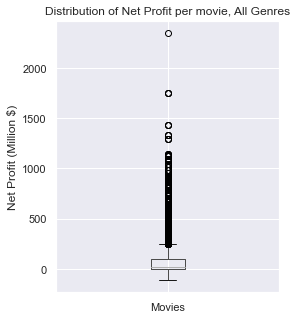

In [29]:
# Create a box and whiskers plot of median profit, 
# to see what the distribution of values looks like
fig, ax = plt.subplots(figsize=(4,5))
millions_df = imdb_tn_split_df[['genres_separated', 'net_profit']].copy()
millions_df.net_profit = millions_df.net_profit / 1000000
millions_df.columns = ['genres_separated', 'Movies']
millions_df\
.boxplot(column='Movies', ax=ax)
ax.set(title='Distribution of Net Profit per movie, All Genres',\
       ylabel='Net Profit (Million $)');


Seems like there are lots of outliers! For our genre graphs we can use the median to mitigate the effect of the outliers.

Lets take a look at a graph of net profit, to see which types of movies create the most profit!

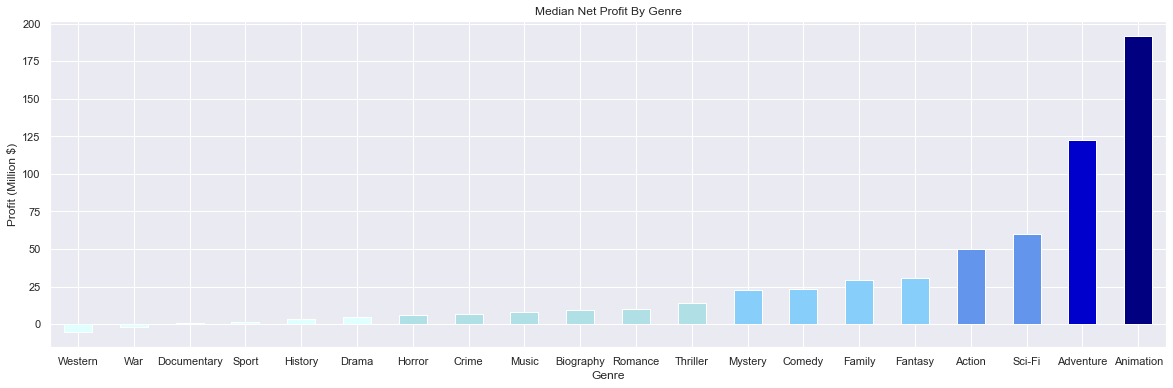

In [70]:
# Graph of how much profit a movie in each genre made, by median value
fig, ax = plt.subplots(figsize=(20,6))
genre_df = genre_df.sort_values('median_net_profit')
net_profit = genre_df.median_net_profit
net_profit.plot.bar(ax=ax, color=\
     ["lightcyan" if (x < net_profit.quantile(.3)) \
      else 'powderblue' if (x < net_profit.quantile(.6))
      else 'lightskyblue' if (x < net_profit.quantile(.8))
      else 'cornflowerblue' if (x < net_profit.quantile(.9))
      else 'mediumblue' if (x < net_profit.quantile(.95))
      else 'navy' for x in net_profit]);
ax.set(title='Median Net Profit By Genre', xlabel='Genre', \
       ylabel='Profit (Million $)');
plt.xticks(rotation=0);

Seems like Animation, Adventure, and Sci-Fi made the most profit-wise. However, Animation studios are radically different from other animation studios, and have a high barrier to entry. So we can focus on the next 3 highest genres, Adventure, Sci-Fi, and Action.

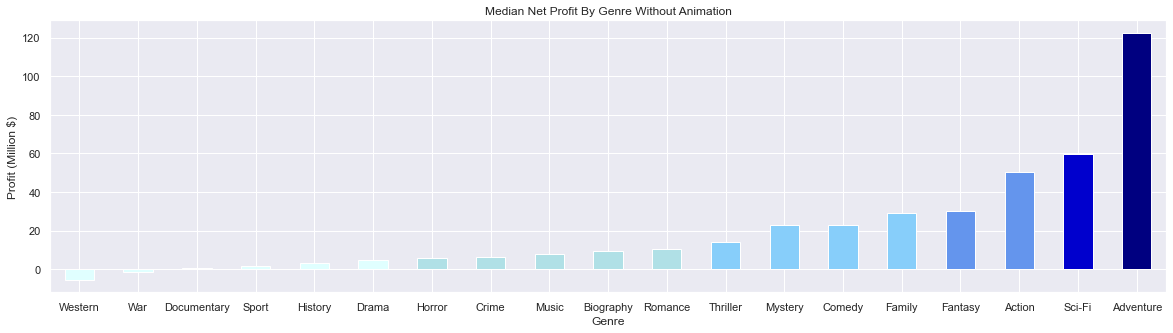

In [60]:
# Graph of how much profit a movie in each genre made, by median value, without 
# animation
fig, ax = plt.subplots(figsize=(20,6))
genre_df = genre_df.sort_values('median_net_profit')
net_profit = genre_df[genre_df.index != 'Animation'].median_net_profit
net_profit.plot.bar(ax=ax, color=\
     ["lightcyan" if (x < net_profit.quantile(.3)) \
      else 'powderblue' if (x < net_profit.quantile(.6))
      else 'lightskyblue' if (x < net_profit.quantile(.8))
      else 'cornflowerblue' if (x < net_profit.quantile(.9))
      else 'mediumblue' if (x < net_profit.quantile(.95))
      else 'navy' for x in net_profit]);
ax.set(title='Median Net Profit By Genre Without Animation', xlabel='Genre', \
       ylabel='Profit (Million $)');
plt.xticks(rotation=0);

Let's quickly take a look at budgets, to see if our selected genres cost too much money to make.

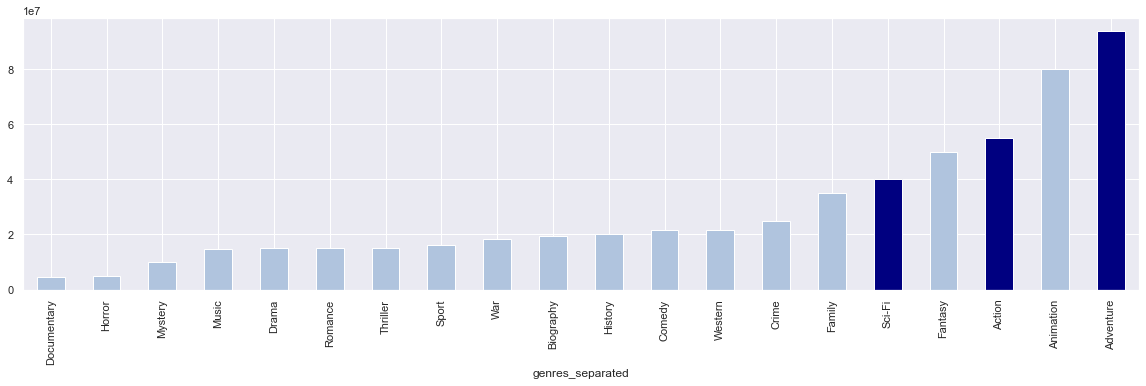

In [32]:
# Graph of how much a movie in each genre cost by median value
fig, ax = plt.subplots(figsize=(20,5))
genre_df = genre_df.sort_values('median_production_budget')
genre_df.median_production_budget.plot.bar(ax=ax, color=\
     ["navy" if (x == 'Action' or x == 'Sci-Fi' or x == 'Adventure' ) \
      else 'lightsteelblue' for x in genre_df.index]);

Hmm, seems like our categories are pretty expensive! They are all in the top 5 of most expensive movies to make! Should we really be choosing these genres? Let's look at the profit ratio to definitively decide if this is a good use of our money.

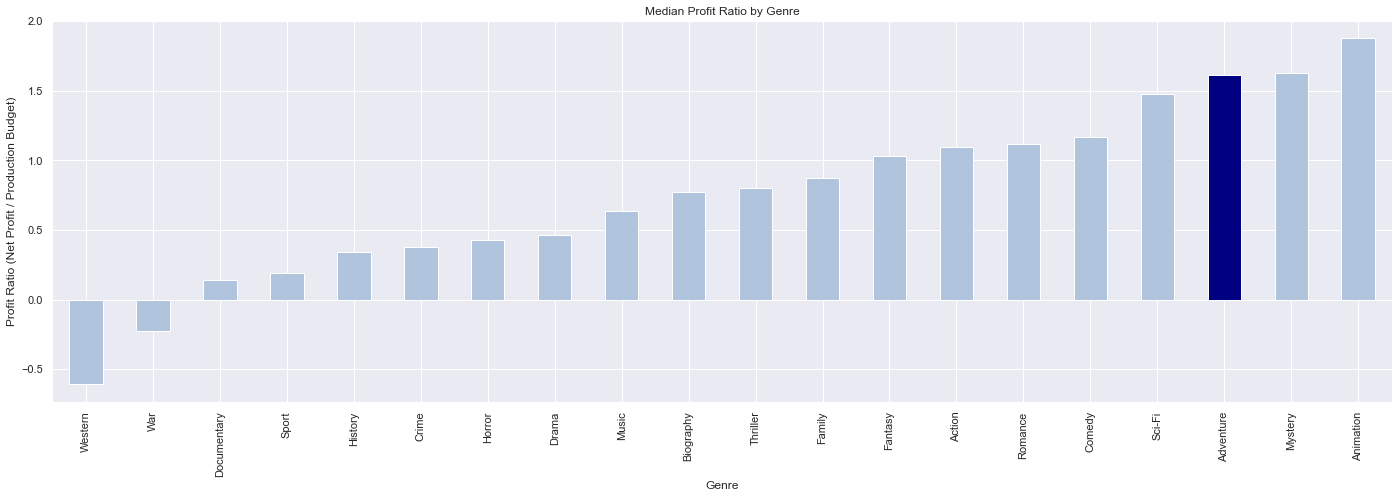

In [56]:
fig, ax = plt.subplots(figsize=(24,7))
genre_df = genre_df.sort_values('median_profit_ratio')
genre_df.median_profit_ratio.plot.bar(ax=ax, color=\
     ["navy" if (x == 'Adventure' ) \
      else 'lightsteelblue' for x in genre_df.index]);
ax.set(title='Median Profit Ratio by Genre', xlabel='Genre', \
       ylabel='Profit Ratio (Net Profit / Production Budget)');

In [34]:
imdb_tn_tmdb_df.numvotes.median()

43792.0

Looks like they aren't so bad! All 3 categories are in the top third by profit ratio, meaning that they shouldn't be money-sinks. Now, we can be more confident that our Adventure, Sci-Fi, or Action movie has a high liklihood of generating money!

<AxesSubplot:xlabel='numvotes', ylabel='worldwide_gross'>

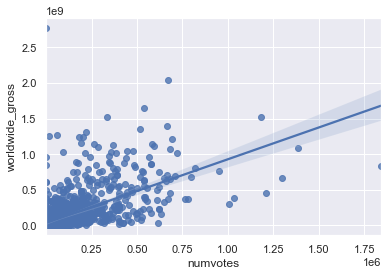

In [35]:
sns.regplot(x='numvotes', y='worldwide_gross', data=imdb_tn_tmdb_df)

# Andrew Yang

## Data Exploration & Cleaning

In [36]:
# nab the tn dataset and clean up columns regarding budget and gross profit
from datetime import datetime
tn_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz").drop("id", axis = 1)
tn_df["production_budget"].replace(["\$",","], "", regex = True, inplace = True)
tn_df["domestic_gross"].replace(["\$",","], "", regex = True, inplace = True)
tn_df["worldwide_gross"].replace(["\$",","], "", regex = True, inplace = True)

# convert budget and profit columns to numeric
cols = ["production_budget","domestic_gross","worldwide_gross"]
tn_df[cols] = tn_df[cols].apply(pd.to_numeric)

# created new columns to grab date information (day, week of year, month, etc.)
tn_df["datetime"] = [datetime.strptime(d, "%b %d, %Y") for d in tn_df["release_date"]]
tn_df["release_weeknum"] = [d.isocalendar()[1] for d in tn_df["datetime"]]
tn_df["release_weekday"] = [d.weekday() for d in tn_df["datetime"]]
tn_df["release_month"] = [d.month for d in tn_df["datetime"]]
tn_df["release_year"] = [d.year for d in tn_df["datetime"]]

# calc movie seasonal info (came out on a weekend, calander season)
tn_df["weekend"]  = np.where((tn_df["release_weekday"]== 5) |
                                  (tn_df["release_weekday"]== 6),
                                    1, 0)   

tn_df.head(5)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009-12-18,51,4,12,2009,0
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011-05-20,20,4,5,2011,0
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019-06-07,23,4,6,2019,0
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015-05-01,18,4,5,2015,0
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017-12-15,50,4,12,2017,0


In [37]:
# null check
#tn_df.info()

In [38]:
# cleaned up dataset by gathering gross profit values and dropping NaN studios
bom_df = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
bom_df["foreign_gross"].replace(",","", regex = True, inplace = True)
bom_df["foreign_gross"] = pd.to_numeric(bom_df["foreign_gross"])
bom_df["foreign_gross"].fillna(bom_df["foreign_gross"].median(), inplace = True)
bom_df["domestic_gross"].fillna(bom_df["domestic_gross"].median(), inplace = True)
bom_df.dropna(subset = ["studio"], inplace = True)
bom_df.head(5)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010


In [39]:
#bom_df.info()

In [40]:
# Grab movie basics info along with average ratings for each from imdb dataset
imdb_df = pd.read_sql('''
SELECT *
FROM movie_basics
    INNER JOIN movie_ratings USING("movie_id")
''',conn)

In [41]:
# Data cleaning to get genre count and runtime minutes
imdb_df.dropna(subset = ["genres"], inplace = True)
imdb_df["runtime_minutes"] = imdb_df["runtime_minutes"].fillna(imdb_df["runtime_minutes"].mean())
imdb_df["genres_list"] = [gs.split(",") for gs in imdb_df["genres"]]
imdb_df["genres_count"] = [len(gs) for gs in imdb_df["genres_list"]]
imdb_df = imdb_df[imdb_df["runtime_minutes"] <= 300]
imdb_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count
0,tt0063540,Sunghursh,Sunghursh,2013,175.000000,"Action,Crime,Drama",7.0,77,"[Action, Crime, Drama]",3
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.000000,"Biography,Drama",7.2,43,"[Biography, Drama]",2
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.000000,Drama,6.9,4517,[Drama],1
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,94.732273,"Comedy,Drama",6.1,13,"[Comedy, Drama]",2
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.000000,"Comedy,Drama,Fantasy",6.5,119,"[Comedy, Drama, Fantasy]",3
...,...,...,...,...,...,...,...,...,...,...
73850,tt9913056,Swarm Season,Swarm Season,2019,86.000000,Documentary,6.2,5,[Documentary],1
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.000000,Documentary,6.2,6,[Documentary],1
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.000000,"Drama,Family",8.7,136,"[Drama, Family]",2
73853,tt9914642,Albatross,Albatross,2017,94.732273,Documentary,8.5,8,[Documentary],1


In [42]:
# merging datasets imdb (cleaned) and bom (cleaned) with inner join
# on movie titles and year of movie release
imdb_df_c = imdb_df.merge(bom_df, how = "inner", 
                          left_on = ["primary_title", "start_year"], 
                          right_on = ["title","year"])
imdb_df_c.head(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,title,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378,"[Action, Crime, Drama]",3,Wazir,Relbig.,1100000.0,18700000.0,2016
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,"[Adventure, Drama, Romance]",3,On the Road,IFC,744000.0,8000000.0,2012
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,"[Adventure, Comedy, Drama]",3,The Secret Life of Walter Mitty,Fox,58200000.0,129900000.0,2013
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,"[Action, Crime, Drama]",3,A Walk Among the Tombstones,Uni.,26300000.0,26900000.0,2014
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,"[Action, Adventure, Sci-Fi]",3,Jurassic World,Uni.,652300000.0,1019.4,2015


In [43]:
# merging datasets imdb_c (cleaned) and tn (cleaned) with inner join
# on movie titles and year of movie release
imdb_df_c2 = imdb_df_c.merge(tn_df, how = "inner", 
                             left_on = ["primary_title", "start_year"], 
                             right_on = ["movie","release_year"])

# create release season of movies
seasons = []
for m in imdb_df_c2["release_month"]:
    if(m in [12,1,2]): 
        seasons.append("winter")
    elif(m in [3,4,5]): 
        seasons.append("spring")
    elif(m in [6,7,8]): 
        seasons.append("summer")
    else: 
        seasons.append("fall")

imdb_df_c2["release_season"] = seasons 

# create worldwide profit, adjusted for production budge
imdb_df_c2["adjusted_worldwide"] = imdb_df_c2["worldwide_gross"] - imdb_df_c2["production_budget"]

# it's beautiful
imdb_df_c2.head(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,...,domestic_gross_y,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend,release_season,adjusted_worldwide
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,"[Adventure, Comedy, Drama]",3,...,58236838,187861183,2013-12-25,52,2,12,2013,0,winter,96861183
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,"[Action, Crime, Drama]",3,...,26017685,62108587,2014-09-19,38,4,9,2014,0,fall,34108587
2,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,"[Action, Adventure, Sci-Fi]",3,...,652270625,1648854864,2015-06-12,24,4,6,2015,0,summer,1433854864
3,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787,"[Comedy, Drama]",2,...,13109815,21544732,2011-10-28,43,4,10,2011,0,fall,-23455268
4,tt0383010,The Three Stooges,The Three Stooges,2012,92.0,"Comedy,Family",5.1,28570,"[Comedy, Family]",2,...,44338224,54052249,2012-04-13,15,4,4,2012,0,spring,24052249


In [44]:
#imdb_df_c2.info()

## EDA

<ipython-input-45-a8ec1373fbc0>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


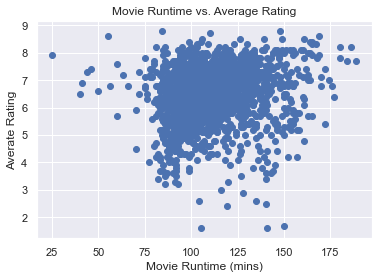

In [45]:
fig, ax = plt.subplots()
ax.scatter(imdb_df_c["runtime_minutes"], imdb_df_c["averagerating"])
ax.set_title("Movie Runtime vs. Average Rating")
ax.set_xlabel("Movie Runtime (mins)")
ax.set_ylabel("Averate Rating")
fig.show()

Text(0, 0.5, 'Frequency')

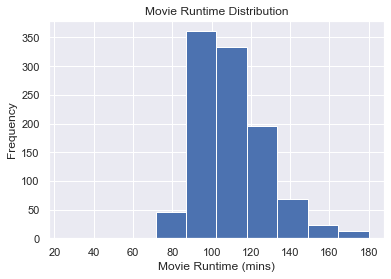

In [46]:
fig, ax = plt.subplots()
ax.hist(imdb_df_c2["runtime_minutes"])
ax.set_title("Movie Runtime Distribution")
ax.set_xlabel("Movie Runtime (mins)")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

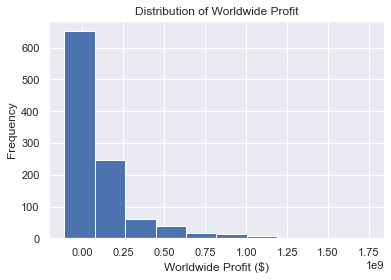

In [47]:
fig, ax = plt.subplots()
ax.hist(imdb_df_c2["adjusted_worldwide"])
ax.set_title("Distribution of Worldwide Profit")
ax.set_xlabel("Worldwide Profit ($)")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Relative Frequency')

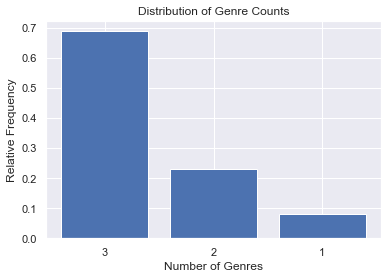

In [48]:
g_count = imdb_df_c2["genres_count"].value_counts(normalize  = True)
labs = [str(x) for x in g_count.index]
fig, ax = plt.subplots()
ax.bar(labs, g_count)
ax.set_title("Distribution of Genre Counts")
ax.set_xlabel("Number of Genres")
ax.set_ylabel("Relative Frequency")

## Hypothesis Testing

### Runtime and Adjusted Worldwide Profit

H0: Movies longer than two hours do not make more worldwide profit than those shorter than two hours.

Ha: Movies longer than two hours do make more worldwide profit than those shorter than two hours.

In [49]:
import scipy.stats as stats

In [50]:
# divide movies by runtime; movies longer or equal to 2 hours are long movies
long_movies = imdb_df_c2[imdb_df_c2["runtime_minutes"]>= 120]
short_movies = imdb_df_c2[imdb_df_c2["runtime_minutes"]< 120]

In [51]:
# conduct two-sample t-test (independent)
results = stats.ttest_ind(long_movies["adjusted_worldwide"], 
                          short_movies["adjusted_worldwide"], alternative = "greater")
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

TypeError: ttest_ind() got an unexpected keyword argument 'alternative'

In [ ]:
# Display split between long and short movie adjusted worldwide profit
fig, ax = plt.subplots()
ax.scatter(long_movies["runtime_minutes"], long_movies["adjusted_worldwide"], label='> 120 minutes')
ax.scatter(short_movies["runtime_minutes"], short_movies["adjusted_worldwide"], label='<= 120 minutes')
ax.set_title("Movie Runtime vs. Worldwide Profit")
ax.set_xlabel("Movie Runtime (mins)")
ax.set_ylabel("Worldwide Profit ($)")
ax.legend(bbox_to_anchor = (1.40, 1))
fig.show()

In [ ]:
# try drawing a correlation line, visualize correlation
import seaborn as sns
sns.set_style('whitegrid')
p = sns.lmplot(x ='runtime_minutes', y ='adjusted_worldwide', data = imdb_df_c2)
p.set(title = "Correlation of Runtime and Worldwide Profit")
p.set(xlabel = "Movie Runtime (mins)", ylabel = "Worldwide Profit ($)")

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].hist(long_movies["adjusted_worldwide"], bins = 10, density = True)
ax[1].hist(short_movies["adjusted_worldwide"], bins = 10, density = True)

ax[0].set_title("Long Movies")
ax[0].set_xlabel("Worldwide Profit ($)")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(right = 1.5 * 10**9)
ax[0].set_ylim(top = 4*10**(-9))

ax[1].set_title("Short Movies")
ax[1].set_xlabel("Worldwide Profit ($)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(right = 1.5 * 10**9)

### Genre Count and Adjusted Worldwide Profit

H0: Movies that occupy three genres do not have higher worldwide profit than those with only one or two genres.

Ha: Movies that occupy three genres do have higher worldwide profit than those with only one or two genres.

In [ ]:
genres_3 = imdb_df_c2[imdb_df_c2["genres_count"]== 3]
genres_1or2 = imdb_df_c2[imdb_df_c2["genres_count"]!= 3]

In [ ]:
results = stats.ttest_ind(genres_3["adjusted_worldwide"], 
                          genres_1or2["adjusted_worldwide"], alternative = "greater")
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

In [ ]:
g_adjWW = imdb_df_c2.groupby("genres_count").median()["adjusted_worldwide"]
labs2 = [str(x) for x in g_adjWW.index]
fig, ax = plt.subplots()
ax.bar(labs2, g_adjWW)
ax.set_title("Median Worldwide Profit within Genre Counts")
ax.set_xlabel("Number of Genres")
ax.set_ylabel("Worldwide Profit ($)")

### Movie Budget and Adjusted Worldwide Profit

H0: Movies with higher budgets do not have larger worldwide profit than those with smaller budgets on average.

Ha: Movies with higher budgets do have larger worldwide profit than those with smaller budgets.

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
p = sns.lmplot(x ='production_budget', y ='adjusted_worldwide', data = imdb_df_c2)
p.set(title = "Correlation of Budget and Worldwide Profit")
p.set(xlabel = "Production Budget ($)", ylabel = "Worldwide Profit ($)")

In [ ]:
high_prod = imdb_df_c2[imdb_df_c2["production_budget"] >= imdb_df_c2["production_budget"].median()]
low_prod = imdb_df_c2[imdb_df_c2["production_budget"] < imdb_df_c2["production_budget"].median()]

In [ ]:
results = stats.ttest_ind(high_prod["adjusted_worldwide"], low_prod["adjusted_worldwide"], alternative = "greater")
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(high_prod["production_budget"], high_prod["adjusted_worldwide"], 
           label = "high budget")
ax.scatter(low_prod["production_budget"], low_prod["adjusted_worldwide"],
          label = "low budget")
ax.set_title("Correlation of Budget and Worldwide Profit")
ax.set_xlabel("Production Budget ($)")
ax.set_ylabel("Worldwide Profit ($)")
ax.legend(bbox_to_anchor = (1.30, 1))

### Seasons and Worldwide Profit

In [ ]:
imdb_df_c2["release_season"].value_counts()

In [ ]:
# group rows by release season, and get medians of each
seasonal_medians = imdb_df_c2.groupby("release_season").median()["adjusted_worldwide"]

# create barplot w/ custom colors
fig, ax = plt.subplots()
c = ['sandybrown', 'forestgreen', 'khaki', 'lightblue']
ax.bar(seasonal_medians.index, seasonal_medians, color = c)
ax.set_title("Seasonal Median Worldwide Profit")
ax.set_xlabel("Release Season")
ax.set_ylabel("Median Worldwide Profit ($)")

In [ ]:
# group rows by release season, and get means of each
seasonal_means = imdb_df_c2.groupby("release_season").mean()["adjusted_worldwide"]

# create barplot w/ custom colors
fig, ax = plt.subplots()
c = ['sandybrown', 'forestgreen', 'khaki', 'lightblue']
ax.bar(seasonal_means.index, seasonal_means, color = c)
ax.set_title("Seasonal Mean Worldwide Profit")
ax.set_xlabel("Release Season")
ax.set_ylabel("Mean Worldwide Profit ($)")

H0: Movies that release in warmer seasons do not have larger worldwide profit than those released in colder ones.

Ha: Movies that release in warmer seasons have larger worldwide profit than those released in colder ones.

In [ ]:
# only rows where season is fall or winter
cold_season = imdb_df_c2[(imdb_df_c2["release_season"] == "winter") | 
                        (imdb_df_c2["release_season"] == "fall")]

# only rows where season is spring or summer
warm_season = imdb_df_c2.loc[(imdb_df_c2["release_season"] == "summer") | 
                             (imdb_df_c2["release_season"] == "spring")]

In [ ]:
results = stats.ttest_ind(warm_season["adjusted_worldwide"], cold_season["adjusted_worldwide"], alternative = "greater")
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

In [ ]:
season_list = []
for s in imdb_df_c2["release_season"]:
    if (s == "winter") | (s == "fall"):
        season_list.append("cold")
    else:
        season_list.append("warm")

imdb_df_c2["season_split"] = season_list

fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(x='adjusted_worldwide', y='season_split', data= imdb_df_c2)
ax.set_xlabel("Worldwide Profit ($)")
ax.set_ylabel("Season")
ax.set_title("Worldwide Profit between Cold and Warm Seasons")

### Visualize the Ideal Movie

In [ ]:
movie_samp = imdb_df_c2.loc[(imdb_df_c2["runtime_minutes"] >= 120) &
                           (imdb_df_c2["season_split"] == "warm") & 
                           [("Adventure" in g) for g in imdb_df_c2["genres_list"]]]
movie_samp[["primary_title", "runtime_minutes", "season_split", "genres_list", 
            "adjusted_worldwide"]].head(5)

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(x='adjusted_worldwide', data= movie_samp)
ax.set_xlabel("Worldwide Profit ($)")
ax.set_title("Worldwide Profit of Ideal Movies")

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
sns.histplot(x='adjusted_worldwide', data= movie_samp)
ax.set_xlabel("Worldwide Profit ($)")
ax.set_title("Worldwide Profit of Ideal Movies")
plt.axvline(movie_samp["adjusted_worldwide"].mean(), color = "r")

In [ ]:
# mean Profit
round(movie_samp["adjusted_worldwide"].mean(),2)

In [ ]:
# median Profit
round(movie_samp["adjusted_worldwide"].median(),2)

In [ ]:
# IQR of Profit
round(movie_samp["adjusted_worldwide"].quantile(.75),2) - round(movie_samp["adjusted_worldwide"].quantile(.25),2)